In [1]:
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx
import multinetx as mx
from mpi4py import MPI
from typing import Dict
import matplotlib.pyplot as plt
from IPython.display import HTML
from dataclasses import dataclass
from repast4py import context as ctx
from repast4py import core, schedule, logging, random 
from matplotlib.animation import FuncAnimation
from repast4py.network import write_network, read_network

In [2]:
def label(layers:list):
    N = layers[0].number_of_nodes()
    for num in range(N):
        for layer in range(len(layers)):
            layers[layer].nodes[num]['layer'] = layer
            layers[layer].nodes[num]['number'] = num
    return layers

In [3]:
# Nodes of each layer
N = 15
G1 = nx.Graph()
G2 = nx.Graph()
G1.add_nodes_from(range(N))
G2.add_nodes_from(range(N))
for i in range(1, 10):
    G1.add_edge(0, i)
for i in [0,4]:
    G1.add_edge(7, i)
additional_edges = [(2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)]
G1.add_edges_from(additional_edges)

for i in range(5, 14):
    G2.add_edge(14, i)
for i in [8,11,14,9]:
    G2.add_edge(7, i)
additional_edges = [(3, 4), (4, 5), (6, 7), (7, 8), (8, 9), (9, 10), (12,14)]
G2.add_edges_from(additional_edges)

In [4]:
# for i in range(N):
#     G1.nodes[i]['layer'] = 1
#     G2.nodes[i]['layer'] = 2
#     G1.nodes[i]['number'] = i
#     G2.nodes[i]['number'] = i

layers = [G1, G2]
label_layers = label(layers)

In [5]:
def create_multilayer_graph(label_layers):
    mg = mx.MultilayerGraph()
    for layer in label_layers:
        mg.add_layer(layer)

    num_layers = len(label_layers)
    nodes_per_layer = label_layers[0].number_of_nodes()

    # Add edges directly using generator expression to save memory
    for layer in range(num_layers - 1):
        start = layer * nodes_per_layer
        next_start = (layer + 1) * nodes_per_layer
        mg.add_edges_from((start + node, next_start + node) for node in range(nodes_per_layer))
    
    return mg

In [6]:
# adj_block = mx.lil_matrix(np.zeros((N*2,N*2)))
# adj_block[0:  N,  N:2*N] = np.identity(N) 
# # Symmetric
# adj_block += adj_block.T
# # Creating multilayer graph
# mg = mx.MultilayerGraph()
# mg.add_layer(G1)
# mg.add_layer(G2)
# mg.layers_interconnect(inter_adjacency_matrix=adj_block)
# mg.set_edges_weights(inter_layer_edges_weight=1)
# mg.set_edges_weights(intra_layer_edges_weight=1)
# pos = mx.get_position(mg,mx.fruchterman_reingold_layout(G1),
#                         layer_vertical_shift=0.2,
#                         layer_horizontal_shift=0.0,
#                         proj_angle=47)
mg = create_multilayer_graph(label_layers)

In [7]:
def display_network(mg):
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(121)
    ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),
            origin='upper',interpolation='nearest',cmap=plt.cm.jet_r)
    ax1.set_title('supra adjacency matrix')

    ax2 = fig.add_subplot(122)
    ax2.axis('off')
    ax2.set_title('edge colored network')
    #mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                    #edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                    #edge_cmap=plt.cm.jet_r)
    plt.show()

In [8]:
write_network(mg, 'rumor_network', 'test10.pb', 1)

/var/folders/sg/zx6g04vn46n2w60j_29q40940000gn/T/ipykernel_79662/3317104351.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  ax1.imshow(mx.adjacency_matrix(mg,weight='weight').todense(),


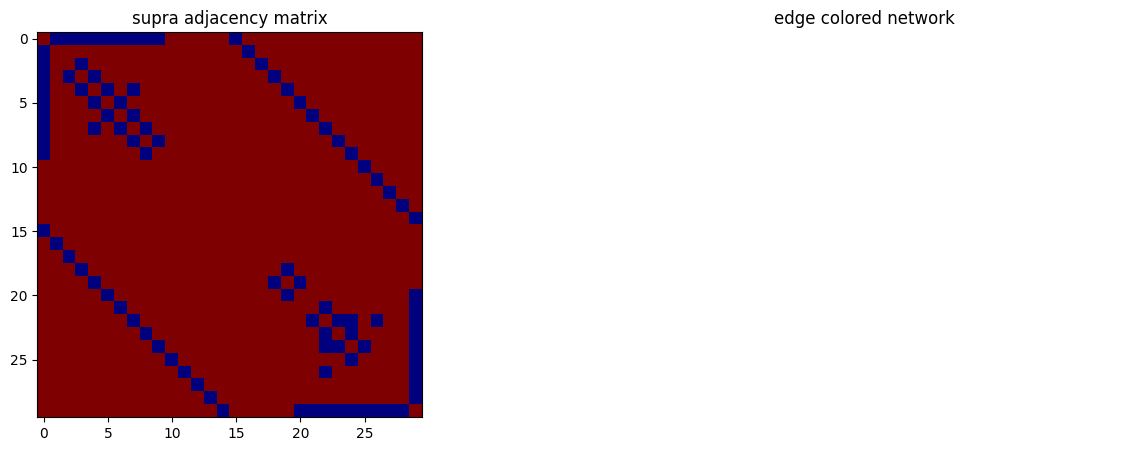

In [9]:
display_network(mg)

In [10]:
model = None
# Rumor Agent 
class RumorAgent(core.Agent):
    def __init__(self, nid: int, agent_type: int, rank: int, received_rumor=False, layer=None, number=None):
        super().__init__(nid, agent_type, rank)
        self.received_rumor = received_rumor
        self.layer = layer
        self.number = number

    def save(self):
        # Ensure that all important attributes are stored
        return (self.uid, self.received_rumor, self.layer, self.number)
    
    # def update(self, data: bool):
    #     if not self.received_rumor and data:
    #         model.rumor_spreaders.append(self)
    #         self.received_rumor = data
    
def create_rumor_agent(nid, agent_type, rank, **kwargs):
    received_rumor = None
    layer = kwargs.get('layer', None)
    number = kwargs.get('number', None)
    return RumorAgent(nid, agent_type, rank, received_rumor, layer, number)

def restore_agent(agent_data):
    uid = agent_data[0]
    received_rumor = agent_data[1]
    layer = agent_data[2]
    number = agent_data[3]
    return RumorAgent(uid[0], uid[1], uid[2], received_rumor, layer, number)
        
def log(agents):
    for agent in agents:
        print(f"Agent {agent.uid}: Rumor_recieve = {agent.received_rumor}")

def find_clone(context, target):
    for agent in context.agents():
        if agent.layer != target.layer:
            if agent.number == target.number:
                return agent


In [11]:
@dataclass
class RumorCounts:
    total_rumor_spreaders: int
    new_rumor_spreaders: int

In [12]:
def categorize_agents(model_instance):
    """Categorizes agents into dynamically named layer sets based on their layer attribute and assigns them to the model instance."""
    if not hasattr(model_instance, 'context'):
        raise AttributeError("The model instance lacks a 'context' attribute.")
    
    # Dictionary to temporarily store each layer's agents
    layer_dict = {}

    # Categorize agents by their layer attribute
    for agent in model_instance.context.agents():
        layer = agent.layer
        # Initialize the set for this layer if it doesn't exist in the dictionary
        if layer not in layer_dict:
            layer_dict[layer] = set()
        # Add the agent to the corresponding layer set
        layer_dict[layer].add(agent)
    
    # Assign each set in layer_dict back to the model as a unique attribute
    for layer, agents in layer_dict.items():
        setattr(model_instance, f'layer_{layer}', agents)


In [13]:
class Model:     
    def __init__(self, comm, params):
        self.runner = schedule.init_schedule_runner(comm)
        self.runner.schedule_repeating_event(1, 1, self.prepare, 0)
        self.runner.schedule_repeating_event(1, 1, self.step1, 3, 1)
        self.runner.schedule_repeating_event(1, 1, self.step2, 3, 1)
        self.runner.schedule_repeating_event(1, 1, self.update, 1)
        self.runner.schedule_stop(params['stop.at'])
        self.runner.schedule_end_event(self.at_end)

        fpath = params['network_file']
        self.context = ctx.SharedContext(comm)
        read_network(fpath, self.context, create_rumor_agent, restore_agent)
        self.net = self.context.get_projection('rumor_network')
        
        categorize_agents(self)

        self.new_rumor_spreaders = set()
        self.rumor_spreaders = set()
        self.rank = comm.Get_rank()
        
        self._seed_rumor(params['initial_rumor_count'], comm, params['nodes'], params['seed'])

        rumored_count = len(self.rumor_spreaders)
        self.counts = RumorCounts(total_rumor_spreaders=rumored_count, new_rumor_spreaders=0)
        loggers = logging.create_loggers(self.counts, op=MPI.SUM, rank=self.rank)
        self.data_set = logging.ReducingDataSet(loggers, comm, params['counts_file'])
        self.data_set.log(0)
        self.rumor_prob = params['rumor_probability']


    def _seed_rumor(self, init_rumor_count: int, comm, N, target):
        world_size = comm.Get_size()
        # np array of world size, the value of i'th element of the array
        # is the number of rumors to seed on rank i.
        rumor_counts = np.zeros(world_size, np.int32)
        if (self.rank == 0):
            for _ in range(init_rumor_count):
                idx = random.default_rng.integers(0, high=world_size)
                rumor_counts[idx] += 1

        rumor_count = np.empty(1, dtype=np.int32)
        comm.Scatter(rumor_counts, rumor_count, root=0)
        
        for agent in self.context.agents():
            if agent.number == target:
                agent.received_rumor = True
                self.rumor_spreaders.add(agent)
        
    def at_end(self):
        self.data_set.close()

    def prepare(self):
        self.new_rumor_spreaders = set()

    def step1(self):
        self._process_agents(1)

    def step2(self):
        self._process_agents(2)

    def _process_agents(self, layer):
        rng = np.random.default_rng()
        for agent in self.rumor_spreaders:
            if agent.layer == layer:
                for ngh in self.net.graph.neighbors(agent):
                    if (not ngh.received_rumor
                        and rng.uniform() <= self.rumor_prob):
                        self.new_rumor_spreaders.add(ngh)
                        ngh.received_rumor = True
                        clone = find_clone(self.context, ngh)
                        clone.received_rumor = True
                        self.new_rumor_spreaders.add(clone)

    def update(self):
        self.rumor_spreaders.update(self.new_rumor_spreaders)
        self.counts.new_rumor_spreaders = len(self.new_rumor_spreaders)
        self.counts.total_rumor_spreaders = len(self.rumor_spreaders)
        self.data_set.log(self.runner.schedule.tick)
        self.context.synchronize(restore_agent)

    def tick_log(self):
        log(self.context.agents())

    def start(self):
        self.runner.execute()

    def reset(self):
        # Reset the schedule runner
        self.runner.reset()

        # Reset the rumor spreaders list
        self.rumor_spreaders = set()
        self.new_rumor_spreaders = set()

        # Reset the counts
        self.counts.reset()

        # Reset the data set
        self.data_set.reset()

        # Reset the color array
        self.color = np.zeros((self.params['stop.at'], 2 * self.params['nodes']), dtype=int)

        # Reseed the rumor
        self._seed_rumor(self.params['initial_rumor_count'], self.comm, self.params['nodes'])


In [14]:
def run(params: Dict = None):
    global model
    if params is None:
        params = {}

    # Default values
    
    defaults = {
        # Model params
        'nodes': 15,
        'stop.at': 49,
        'initial_rumor_count': 1,
        'seed': 0,
        'network_file': 'test10.pb',
        'counts_file': 'output/rumor_counts.csv',
        # Agent params
        'rumor_probability': 0.02,
    }

    # Update defaults with provided params
    combined_params = {**defaults, **params}

    model = Model(MPI.COMM_WORLD, combined_params)
    model.start()

NUM_RUN = 1
def reset():
    model.reset()

if __name__ == "__main__":
    if not MPI.Is_initialized():
        MPI.Init()
    try:
        for i in range(1,16):
            for j in range(NUM_RUN):
                run({'seed': i, 'counts_file': f'output/output_seed{i}/rumor_counts.csv'})
    finally:
        if MPI.Is_initialized():
            MPI.Finalize()


Directory: output/output_seed1 - Number of files processed: 1
Averaged data for output/output_seed1: [1. 1. 1. 1. 1.]...
Directory: output/output_seed2 - Number of files processed: 1
Averaged data for output/output_seed2: [1. 1. 1. 1. 1.]...
Directory: output/output_seed3 - Number of files processed: 1
Averaged data for output/output_seed3: [1. 1. 1. 1. 1.]...
Directory: output/output_seed4 - Number of files processed: 1
Averaged data for output/output_seed4: [1. 1. 1. 1. 1.]...
Directory: output/output_seed5 - Number of files processed: 1
Averaged data for output/output_seed5: [1. 2. 3. 4. 5.]...
Directory: output/output_seed6 - Number of files processed: 1
Averaged data for output/output_seed6: [1. 1. 1. 2. 3.]...
Directory: output/output_seed7 - Number of files processed: 1
Averaged data for output/output_seed7: [1. 1. 1. 1. 3.]...
Directory: output/output_seed8 - Number of files processed: 1
Averaged data for output/output_seed8: [1. 1. 1. 1. 1.]...
Directory: output/output_seed9 -

/var/folders/sg/zx6g04vn46n2w60j_29q40940000gn/T/ipykernel_79662/2252097373.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(averaged_data))  # Get a colormap with enough colors


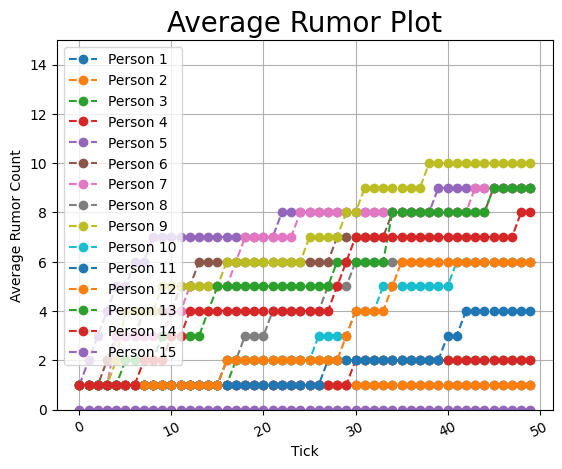

In [15]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

# Function to read CSV and return x, y values
def read_csv(file_path):
    x = []
    y = []
    with open(file_path, 'r') as csvfile:
        lines = csv.reader(csvfile, delimiter=',')
        next(lines)
        for row in lines:
            x.append(int(row[0]))
            y.append(float(row[1]) / 2.0)
    return x, y

# Function to process all CSV files in a directory
def process_directory(dir_name):
    data = []
    for i in range(100):
        file_path = f"{dir_name}/rumor_counts_{i}.csv" if i >= 1 else f"{dir_name}/rumor_counts.csv"
        if os.path.exists(file_path):
            _, y = read_csv(file_path)
            data.append(y)
    if data:
        print(f"Directory: {dir_name} - Number of files processed: {len(data)}")  # Print number of files processed
        return np.mean(data, axis=0)
    else:
        print(f"Directory: {dir_name} - No files found or processed.")
        return None

# Process all 15 directories
directories = [f'output/output_seed{i}' for i in range(1,16)]
averaged_data = []

for dir_name in directories:
    avg_data = process_directory(dir_name)
    if avg_data is not None:
        print(f"Averaged data for {dir_name}: {avg_data[:5]}...")  # Print first 5 values of averaged data
        averaged_data.append(avg_data)

# Assuming all CSV files have the same x-axis values, read from one file
x, _ = read_csv(f"{directories[0]}/rumor_counts.csv")

# Plotting the data
colors = plt.cm.get_cmap('tab10', len(averaged_data))  # Get a colormap with enough colors

for i, data in enumerate(averaged_data):
    plt.plot(x, data, linestyle='dashed', marker='o', label=f'Person {i+1}')

# After the plotting loop
plt.ylim(0, 15)  # Set y-axis limits; adjust max_y_value as appropriate
plt.xticks(rotation=25)
plt.xlabel('Tick')
plt.ylabel('Average Rumor Count')
plt.title('Average Rumor Plot', fontsize=20)
plt.grid()
plt.legend()
plt.savefig('average_rumor_plot_all.png', dpi=300)  # Save as PNG file with high resolution

plt.show()

tick_index = 49  # Tick 49 corresponds to index 49
average_rumor_at_tick_49 = np.mean([data[tick_index] for data in averaged_data])
